In [1]:
import time_series_numerical_predictor as predictor
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

look_back = 40

# 데이터셋 생성
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

x_train, y_train = predictor.create_dataset(train, look_back)
x_val, y_val = predictor.create_dataset(val, look_back)
x_test, y_test = predictor.create_dataset(test, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 모델 구성
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 모델 학습과정 설정
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
from time_series_numerical_predictor import CustomHistory
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

Using TensorFlow backend.


Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 14s 18ms/step - loss: 0.0282 - val_loss: 0.0219
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 13s 17ms/step - loss: 0.0089 - val_loss: 0.0015
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 13s 17ms/step - loss: 0.0067 - val_loss: 0.0013
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 13s 17ms/step - loss: 0.0051 - val_loss: 0.0018
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 13s 17ms/step - loss: 0.0050 - val_loss: 0.0010
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 13s 17ms/step - loss: 0.0041 - val_loss: 0.0020
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 13s 17ms/step - los

760/760 [==============================] - 7s 9ms/step - loss: 0.0025 - val_loss: 1.0284e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0019 - val_loss: 2.3359e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0021 - val_loss: 1.5366e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0021 - val_loss: 2.1945e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0022 - val_loss: 0.0025
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0023 - val_loss: 4.2058e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0023 - val_loss: 3.9470e-04
Train on 760 samp

760/760 [==============================] - 7s 9ms/step - loss: 0.0020 - val_loss: 7.6812e-05
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0020 - val_loss: 3.9987e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0019 - val_loss: 2.4922e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0020 - val_loss: 1.2402e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0021 - val_loss: 5.6153e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0021 - val_loss: 2.7415e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0020 - val_loss: 1.7514e-04
Train on 760 

760/760 [==============================] - 7s 10ms/step - loss: 0.0020 - val_loss: 1.5088e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0021 - val_loss: 1.8952e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0021 - val_loss: 3.9883e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0020 - val_loss: 5.9051e-05
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0018 - val_loss: 2.0231e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0019 - val_loss: 1.8418e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s 9ms/step - loss: 0.0019 - val_loss: 3.0047e-04
Train on 760

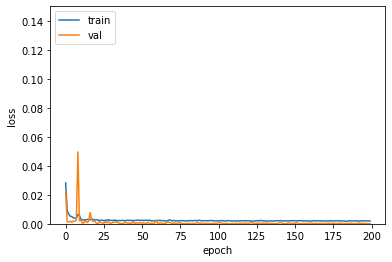

In [2]:
# 학습 과정 출력
predictor.show_model_learning_process(custom_hist.train_loss, custom_hist.val_loss)

# 모델 평가
predictor.evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=1)

# 모델 사용
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])

predictor.print_used_model(y_test, look_ahead, predictions)